In [1]:
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import numpy as np
import math

from gym_brt.quanser import QubeSimulator
from gym_brt.quanser.qube_interfaces import (
    forward_model_ode,
    forward_model_euler,
)

from gym_brt.control import (
    zero_policy,
    constant_policy,
    square_wave_policy,
    pd_control_policy,
    flip_and_hold_policy,
    square_wave_flip_and_hold_policy,
)


# Helper functions

In [2]:
def run_sim(forward_model, init_state, policy, nsteps, frequency, integration_steps):
    qube = QubeSimulator(
        forward_model=forward_model,
        frequency=frequency,
        integration_steps=integration_steps,
        max_voltage=3.0
    )
    qube.state = np.asarray(init_state, dtype=np.float64)  # Set the initial state of the simulator

    s = init_state
    a = policy(s, step=0)
    s_hist = [s]
    a_hist = [a]

    for i in range(nsteps):
        s = qube.step(a)
        a = policy(s, step=i+1)

        s_hist.append(s) # States
        a_hist.append(a) # Actions

    # Return a 2d array, hist[n,d] gives the nth timestep and the dth dimension
    # Dims are ordered as: ['Theta', 'Alpha', 'Theta dot', 'Alpha dot', 'Action']
    hist = np.concatenate((np.array(s_hist), np.array(a_hist)), axis=1)
    hist[:,1] %= 2 * np.pi  # Better for graphing alpha values
    return hist

In [3]:
def plot_results(hists, labels, colors=None):
    state_dims = ['Theta', 'Alpha', 'Theta dot', 'Alpha dot', 'Action']
    
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        if colors is None:
            for hist, label in zip(hists, labels):
                ax.plot(hist[:,i], label=label)
        else:
            for hist, label, color in zip(hists, labels, colors):
                ax.plot(hist[:,i], label=label, color=color)
        ax.set_ylabel(state_dims[i])
        ax.legend()
    plt.show()

# Run experiments

In [4]:
# Constants between experiments
frequency = 250 # in Hz
run_time = 5 # in seconds
nsteps = int(run_time * frequency)

# To select different number of steps for both (euler is faster with Numba)
i_steps_euler = 5
i_steps_ode   = 1

In [5]:
plt.rcParams["figure.figsize"] = (20,20) # make graphs BIG

# Natural responses

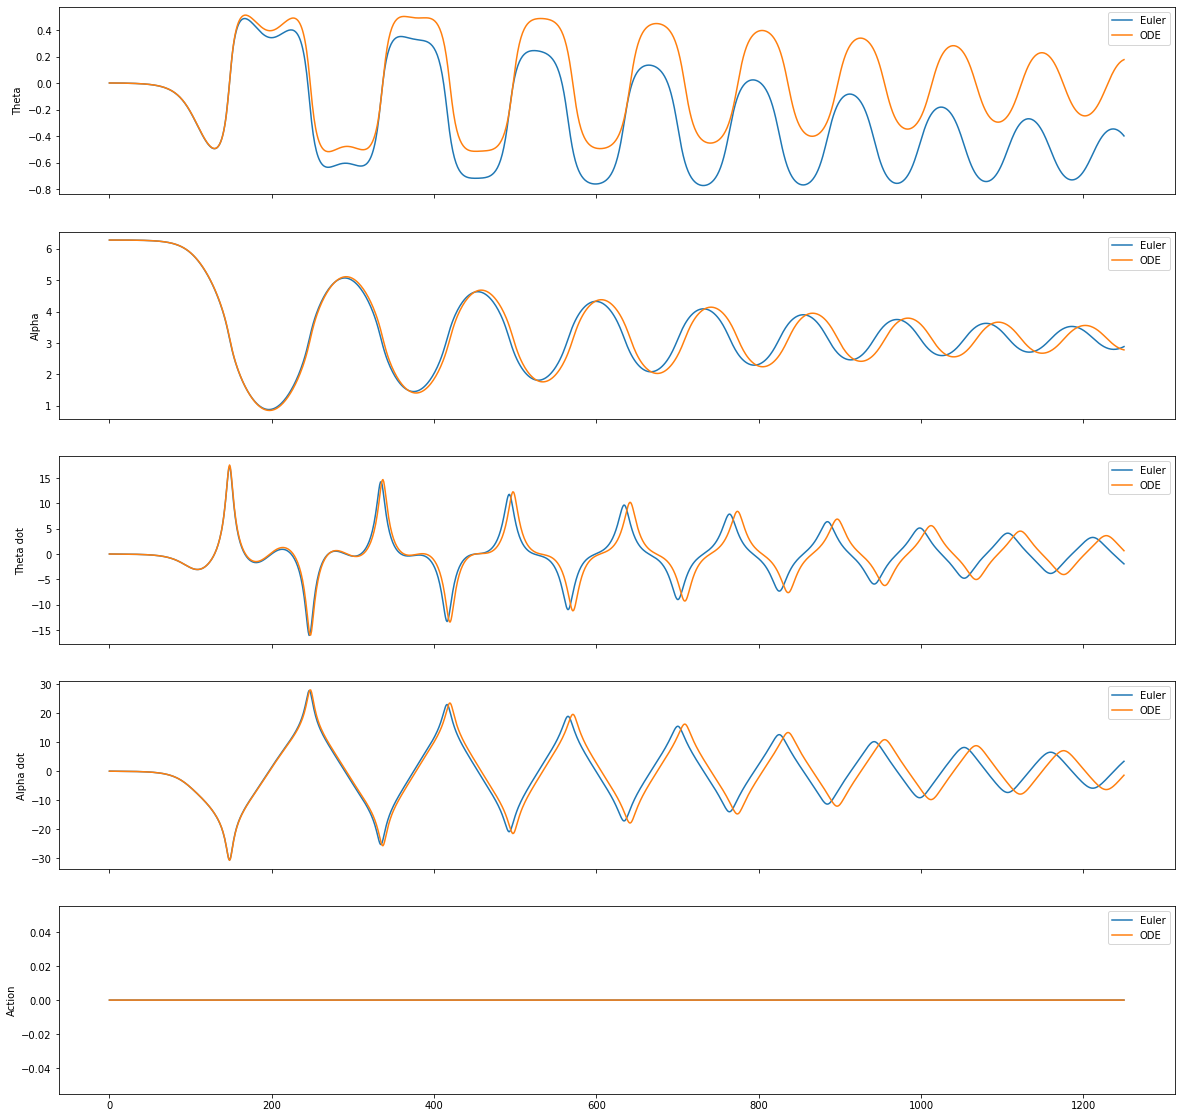

In [6]:
# Natural response when starting at α = 0 + noise (upright/inverted)
init_state  = np.asarray([0, 0, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.01

hist_euler = run_sim(forward_model_euler, init_state, zero_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, zero_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)

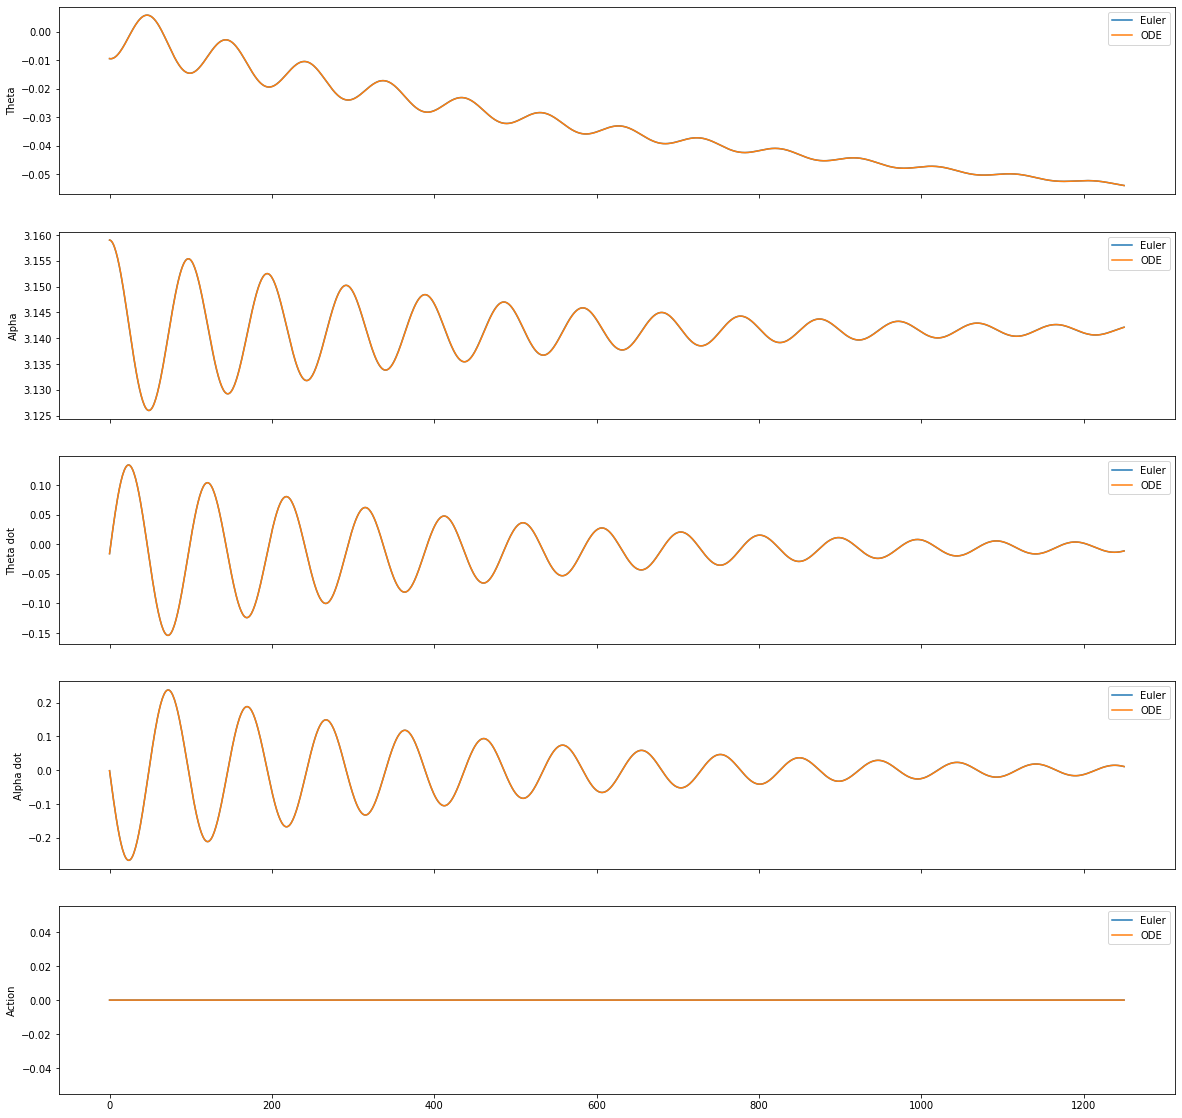

In [7]:
# Natural response when starting at α = π + noise (downwards/at rest)
init_state  = np.asarray([0, np.pi, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.01

hist_euler = run_sim(forward_model_euler, init_state, zero_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, zero_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)

# Forced response

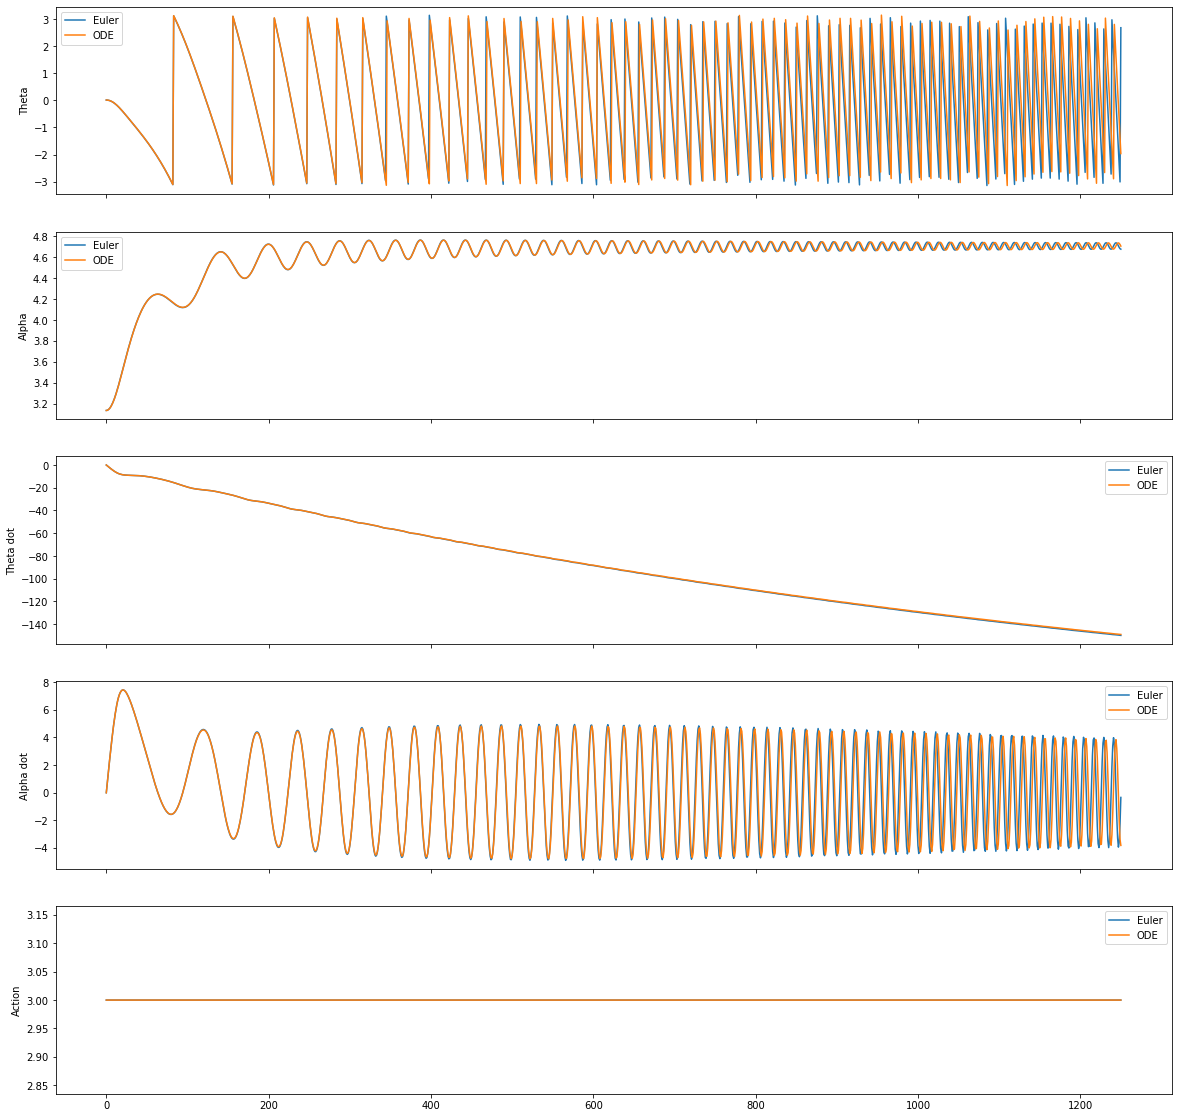

In [8]:
# Focred responce when starting at α = π + noise (downwards/at rest), and using a constant policy
init_state  = np.asarray([0, np.pi, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.01

hist_euler = run_sim(forward_model_euler, init_state, constant_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, constant_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)

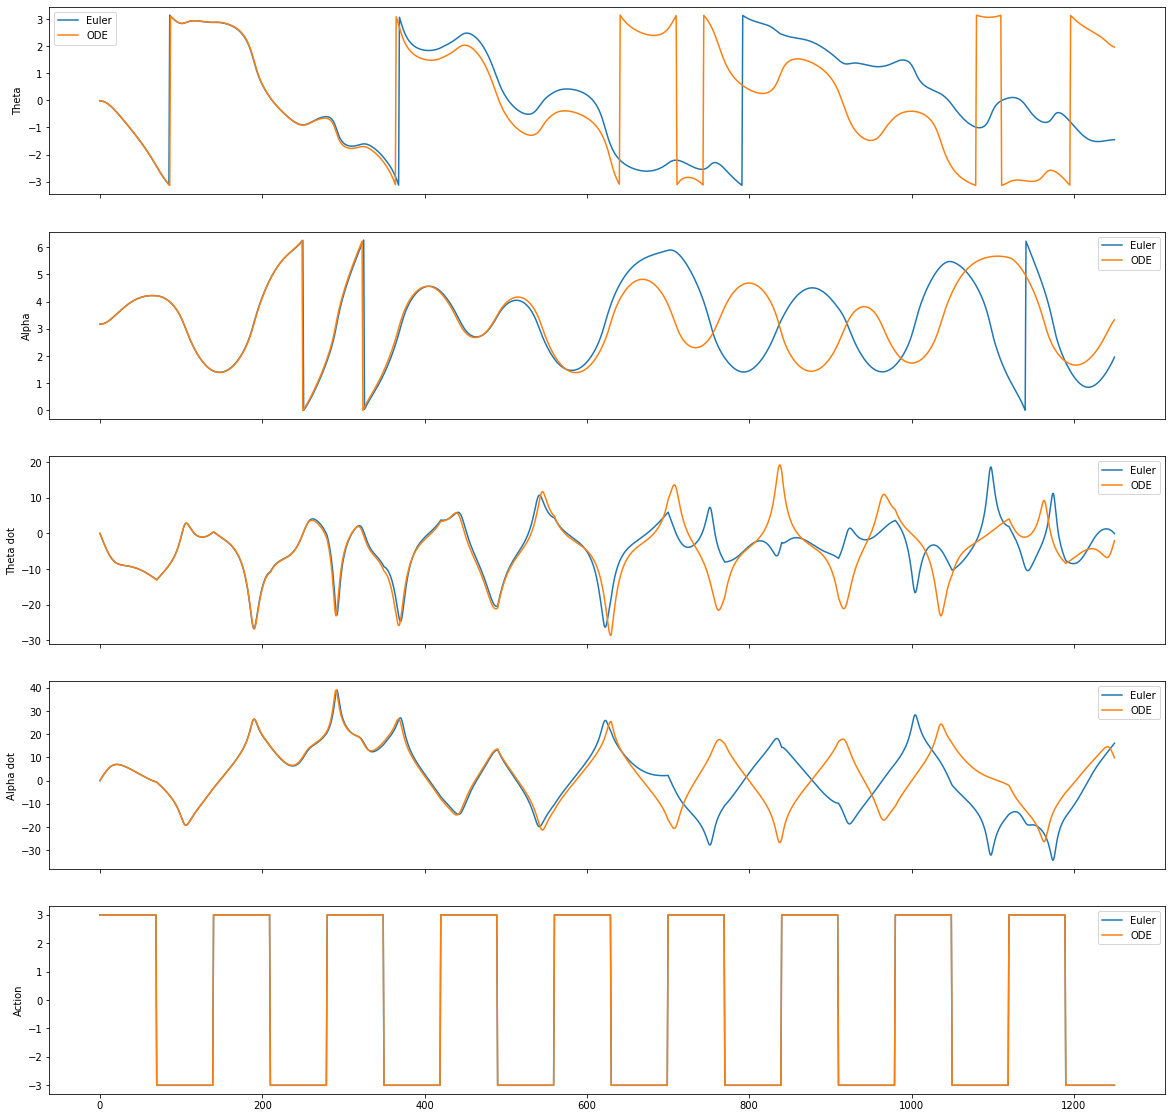

In [9]:
# Forced response when starting at α = π + noise (downwards/at rest), and using a policy that 
# switches direction every 85 steps
init_state  = np.asarray([0, np.pi, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.01

hist_euler = run_sim(forward_model_euler, init_state, square_wave_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, square_wave_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)

# PD controller (starting inverted)

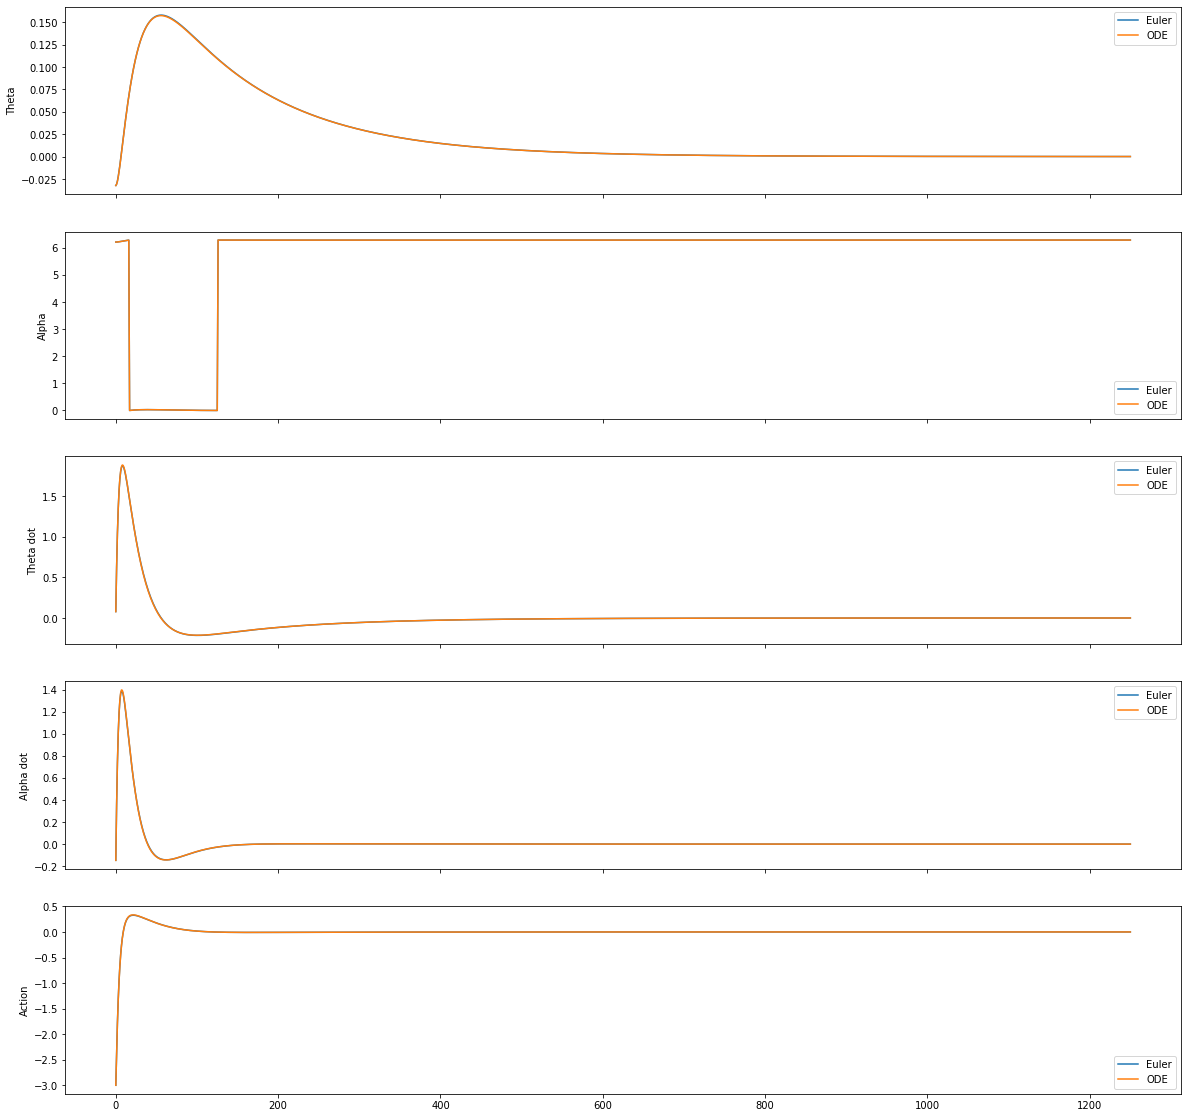

In [10]:
# PD controller to hold when starting at α = 0 + noise (inverted)
init_state  = np.asarray([0, 0, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.1

hist_euler = run_sim(forward_model_euler, init_state, pd_control_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, pd_control_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)

# Energy + PD controller to flip and hold (starting down)

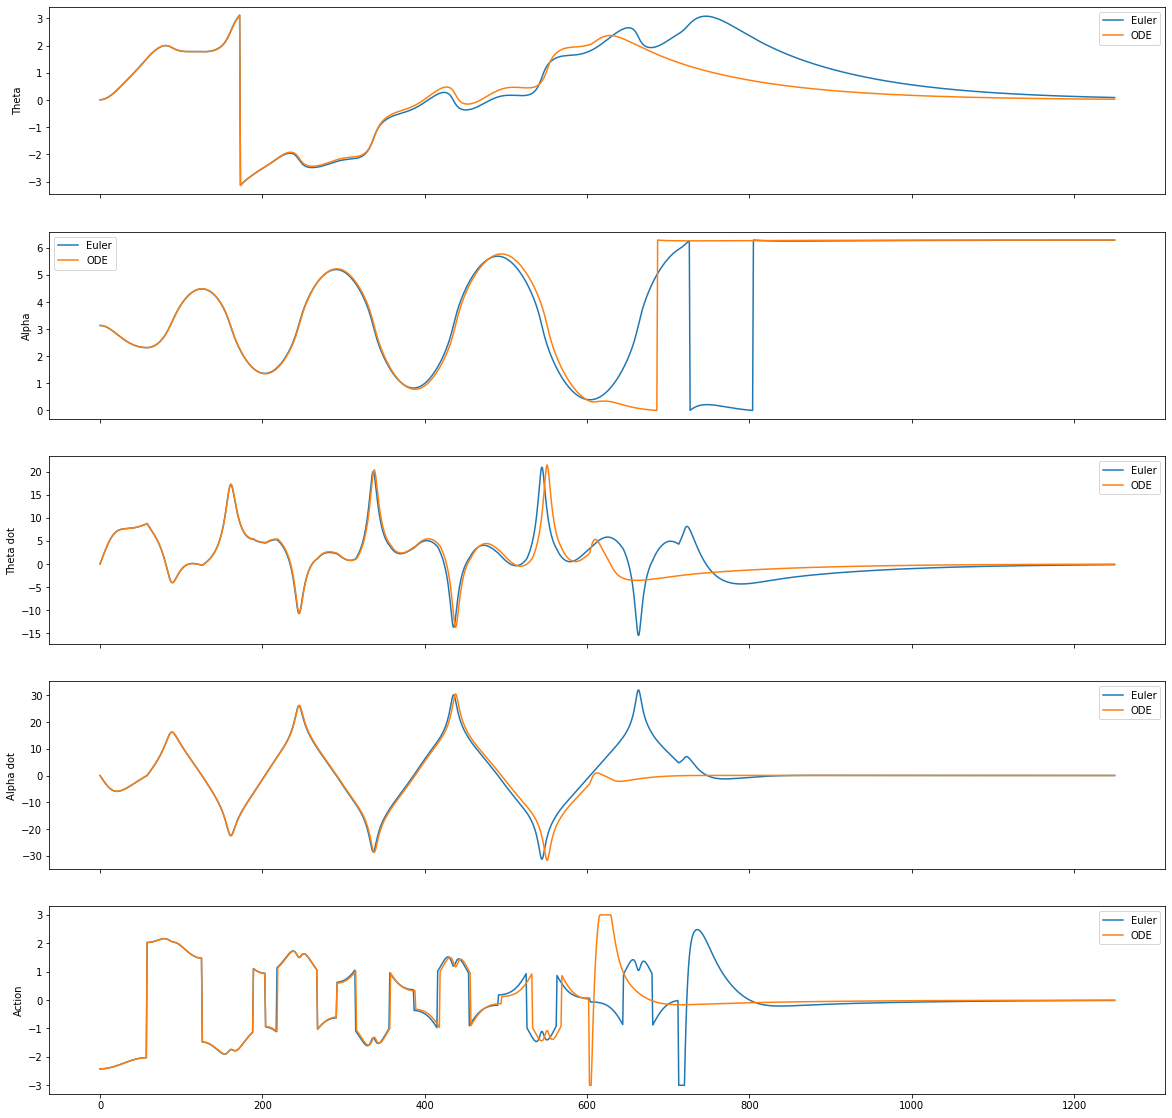

In [11]:
# Energy + PD controller to hold when starting at α = π + noise (inverted)
init_state  = np.asarray([0, np.pi, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.01

hist_euler = run_sim(forward_model_euler, init_state, flip_and_hold_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, flip_and_hold_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)

# Square wave + PD controller to flip and hold (starting down)
This often seems to work on the Qube, so it should work on the sim too

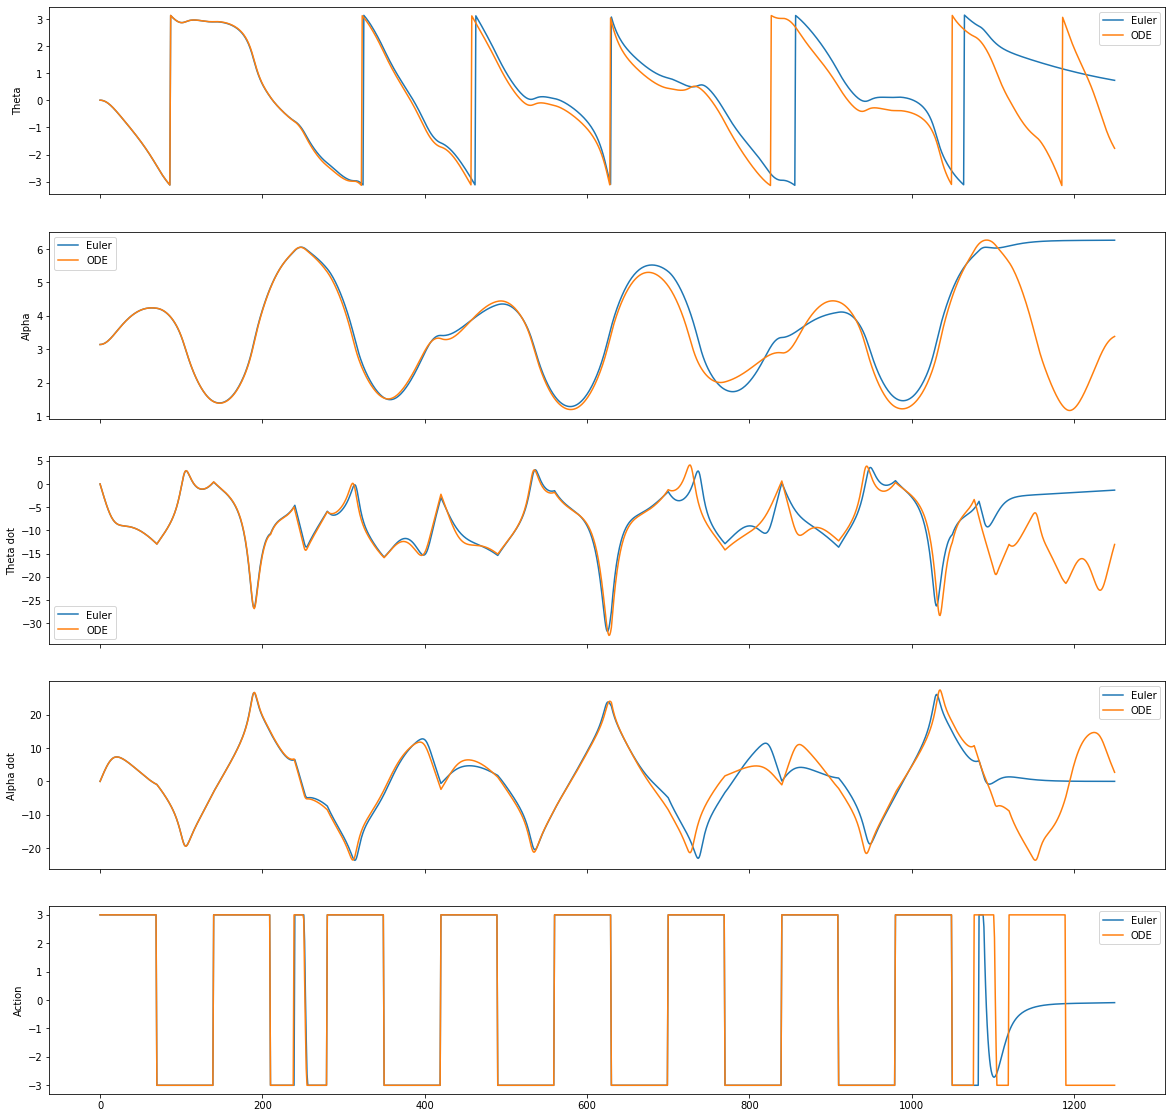

In [12]:
# Energy + PD controller to hold when starting at α = π + noise (inverted)
init_state  = np.asarray([0, np.pi, 0, 0], dtype=np.float32)
init_state += np.random.randn(*init_state.shape) * 0.01

hist_euler = run_sim(forward_model_euler, init_state, square_wave_flip_and_hold_policy, nsteps, frequency, i_steps_euler)
hist_ode   = run_sim(forward_model_ode,   init_state, square_wave_flip_and_hold_policy, nsteps, frequency, i_steps_ode)

plot_results(hists=[hist_euler, hist_ode], labels=['Euler', 'ODE'], colors=None)